In [ ]:
import torch


class TransformerNet(torch.nn.Module):
    def __init__(self):
        super(TransformerNet, self).__init__()
        # Initial convolution layers
        self.conv1 = ConvLayer(3, 32, kernel_size=9, stride=1)
        self.in1 = torch.nn.InstanceNorm2d(32, affine=True)
        self.conv2 = ConvLayer(32, 64, kernel_size=3, stride=2)
        self.in2 = torch.nn.InstanceNorm2d(64, affine=True)
        self.conv3 = ConvLayer(64, 128, kernel_size=3, stride=2)
        self.in3 = torch.nn.InstanceNorm2d(128, affine=True)
        # Residual layers
        self.res1 = ResidualBlock(128)
        self.res2 = ResidualBlock(128)
        self.res3 = ResidualBlock(128)
        self.res4 = ResidualBlock(128)
        self.res5 = ResidualBlock(128)
        # Upsampling Layers
        self.deconv1 = UpsampleConvLayer(128, 64, kernel_size=3, stride=1, upsample=2)
        self.in4 = torch.nn.InstanceNorm2d(64, affine=True)
        self.deconv2 = UpsampleConvLayer(64, 32, kernel_size=3, stride=1, upsample=2)
        self.in5 = torch.nn.InstanceNorm2d(32, affine=True)
        self.deconv3 = ConvLayer(32, 3, kernel_size=9, stride=1)
        # Non-linearities
        self.relu = torch.nn.ReLU()

    def forward(self, X):
        y = self.relu(self.in1(self.conv1(X)))
        y = self.relu(self.in2(self.conv2(y)))
        y = self.relu(self.in3(self.conv3(y)))
        y = self.res1(y)
        y = self.res2(y)
        y = self.res3(y)
        y = self.res4(y)
        y = self.res5(y)
        y = self.relu(self.in4(self.deconv1(y)))
        y = self.relu(self.in5(self.deconv2(y)))
        y = self.deconv3(y)
        return y


class ConvLayer(torch.nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride):
        super(ConvLayer, self).__init__()
        reflection_padding = kernel_size // 2
        self.reflection_pad = torch.nn.ReflectionPad2d(reflection_padding)
        self.conv2d = torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride)

    def forward(self, x):
        out = self.reflection_pad(x)
        out = self.conv2d(out)
        return out


class ResidualBlock(torch.nn.Module):
    """ResidualBlock
    introduced in: https://arxiv.org/abs/1512.03385
    recommended architecture: http://torch.ch/blog/2016/02/04/resnets.html
    """

    def __init__(self, channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = ConvLayer(channels, channels, kernel_size=3, stride=1)
        self.in1 = torch.nn.InstanceNorm2d(channels, affine=True)
        self.conv2 = ConvLayer(channels, channels, kernel_size=3, stride=1)
        self.in2 = torch.nn.InstanceNorm2d(channels, affine=True)
        self.relu = torch.nn.ReLU()

    def forward(self, x):
        residual = x
        out = self.relu(self.in1(self.conv1(x)))
        out = self.in2(self.conv2(out))
        out = out + residual
        return out


class UpsampleConvLayer(torch.nn.Module):
    """UpsampleConvLayer
    Upsamples the input and then does a convolution. This method gives better results
    compared to ConvTranspose2d.
    ref: http://distill.pub/2016/deconv-checkerboard/
    """

    def __init__(self, in_channels, out_channels, kernel_size, stride, upsample=None):
        super(UpsampleConvLayer, self).__init__()
        self.upsample = upsample
        reflection_padding = kernel_size // 2
        self.reflection_pad = torch.nn.ReflectionPad2d(reflection_padding)
        self.conv2d = torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride)

    def forward(self, x):
        x_in = x
        if self.upsample:
            x_in = torch.nn.functional.interpolate(x_in, mode='nearest', scale_factor=self.upsample)
        out = self.reflection_pad(x_in)
        out = self.conv2d(out)
        return out

In [ ]:
!pip install av

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 32.9/32.9 MB 41.4 MB/s eta 0:00:00


In [ ]:
from torchvision import transforms
import torch
import numpy as np
import av

# Mean and standard deviation used for pre-trained PyTorch models
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])


def extract_frames(video_path):
    """ Extracts frames from video """
    frames = []
    video = av.open(video_path)
    for frame in video.decode(0):
        yield frame.to_image()


def gram_matrix(y):
    """ Returns the gram matrix of y (used to compute style loss) """
    (b, c, h, w) = y.size()
    features = y.view(b, c, w * h)
    features_t = features.transpose(1, 2)
    gram = features.bmm(features_t) / (c * h * w)
    return gram


def train_transform(image_size):
    """ Transforms for training images """
    transform = transforms.Compose(
        [
            transforms.Resize(int(image_size * 1.15)),
            transforms.RandomCrop(image_size),
            transforms.ToTensor(),
            transforms.Normalize(mean, std),
        ]
    )
    return transform


def style_transform(image_size=None):
    """ Transforms for style image """
    resize = [transforms.Resize(image_size)] if image_size else []
    transform = transforms.Compose(resize + [transforms.ToTensor(), transforms.Normalize(mean, std)])
    return transform


def denormalize(tensors):
    """ Denormalizes image tensors using mean and std """
    for c in range(3):
        tensors[:, c].mul_(std[c]).add_(mean[c])
    return tensors

In [ ]:
import time
from collections import namedtuple
import matplotlib.pyplot as plt
import numpy as np
import torch
# Get the VGG model
import torchvision.models.vgg as vgg
import torch.utils.model_zoo as model_zoo
# Image tranformation pipeline
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision import datasets
from torch.optim import Adam
from PIL import Image,ImageFile
from tqdm import tqdm,tqdm_notebook
#from fast_neural_style.transformer_net import TransformerNet
#from fast_neural_style.utils import gram_matrix, recover_image, tensor_normalizer
%matplotlib inline
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [ ]:
!pip install torch

In [ ]:
SEED = 999
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available:
  torch.cuda.manual_seed(SEED)
  kwargs = {'num_workers': 4, 'pin_memory': True}
else:
  kwargs = {}

In [ ]:
class TensorNormalizer(torch.nn.Module):
    def __init__(self, mean, std):
        super().__init__()
        self.mean = mean.view(-1, 1, 1)
        self.std = std.view(-1, 1, 1)

    def __call__(self, tensor):
        """
        Normalize a tensor image with mean and standard deviation.
        """
        return (tensor - self.mean) / self.std

In [ ]:
IMAGE_SIZE = 256
BATCH_SIZE = 4
DATASET = '/content/drive/MyDrive/data_coco'
# Define mean and std
mean = torch.tensor([0.485, 0.456, 0.406])
std = torch.tensor([0.229, 0.224, 0.225])

# Instantiate your custom normalizer
tensor_normalizer = TensorNormalizer(mean, std)

transform = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.CenterCrop(IMAGE_SIZE),
    transforms.ToTensor(),
    tensor_normalizer  # Use the instance of your custom class
])

train_dataset = datasets.ImageFolder(DATASET, transform)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, **kwargs)


In [ ]:
LossOutput = namedtuple("LossOutput", ["relu1_2","relu2_2", "relu3_3", "relu4_3"])

class LossNetwork(torch.nn.Module):
  def __init__(self,vgg_model):
    super(LossNetwork, self).__init__()
    self.vgg_layers = vgg_model.features
    self.layer_name_mapping = {
        '3': "relu1_2",
        '8': "relu2_2",
        '15': "relu3_3",
        '22': "relu4_3"
    }

  def forward(self, x):
      output = {}
      for name, module in self.vgg_layers._modules.items():
        x = module(x)
        if name in self.layer_name_mapping:
          output[self.layer_name_mapping[name]] = x
      return LossOutput(**output)


In [ ]:
vgg_model = vgg.vgg16(pretrained = True)
if torch.cuda.is_available():
  vgg_model.cuda()
loss_network = LossNetwork(vgg_model)
loss_network.eval()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 186MB/s]


LossNetwork(
  (vgg_layers): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, 

In [ ]:
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

STYLE_IMAGE = "/content/drive/MyDrive/styles/udnie.jpg"
style_img = Image.open(STYLE_IMAGE).convert("RGB")
with torch.no_grad():
    style_img_tensor = transforms.Compose([
     transforms.ToTensor(),
     tensor_normalizer]
        )(style_img).unsqueeze(0)
    #assert np.sum(style_img - recover_image(style_img_tensor.numpy())[0].astype(np.uint8)) < 3 * style_img_tensor.size()[2] * style_img_tensor.size()[3]
    #style_img_tensor = style_img_tensor.cuda()

In [ ]:
style_img_tensor.size()

torch.Size([1, 3, 1260, 1259])

In [ ]:
import torch
import numpy as np
from PIL import Image

def recover_image(img_tensor):
    # Normalize tensor back to [0, 1] range and move to CPU
    img_tensor = img_tensor.to('cpu').detach()
    mean = torch.tensor([0.485, 0.456, 0.406]).view(1, -1, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(1, -1, 1, 1)
    img_tensor = img_tensor * std + mean
    img_tensor = torch.clamp(img_tensor, 0, 1)

    # Ensure img_tensor is in the expected format (H, W, C) for a single image
    if img_tensor.dim() == 4:
        # If it's a batch, select the first image, assuming you're debugging
        img_tensor = img_tensor[0]
    img_np = img_tensor.permute(1, 2, 0).numpy()

    # Convert numpy array to PIL Image
    img_np = (img_np * 255).astype(np.uint8)
    return Image.fromarray(img_np)

def save_debug_image(tensor_orig, tensor_transformed, filename):
    orig_img = recover_image(tensor_orig)
    transformed_img = recover_image(tensor_transformed)

    # Assuming both images are now PIL Images, combine them
    dst = Image.new('RGB', (orig_img.width + transformed_img.width, max(orig_img.height, transformed_img.height)))
    dst.paste(orig_img, (0, 0))
    dst.paste(transformed_img, (orig_img.width, 0))

    dst.save(filename)


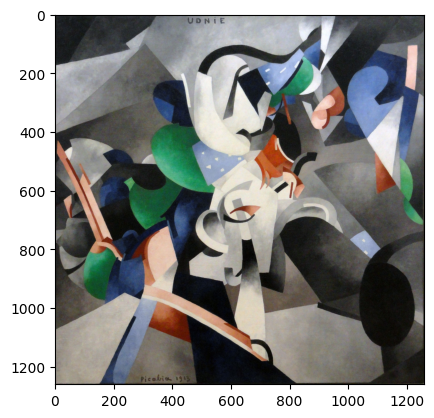

In [ ]:
# Move the tensor to CPU before passing it to recover_image
img_to_display = recover_image(style_img_tensor.squeeze(0).cpu())  # Remove batch dim and move to CPU
plt.imshow(img_to_display)


In [ ]:
# Assuming loss_network is your model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
loss_network = loss_network.to(device)  # Move the model to the appropriate device

# Ensure input tensors are on the same device as the model
style_img_tensor = style_img_tensor.to(device)

with torch.no_grad():
    style_loss_features = loss_network(style_img_tensor)
    gram_style = [gram_matrix(y).data for y in style_loss_features]


In [ ]:
style_loss_features._fields

('relu1_2', 'relu2_2', 'relu3_3', 'relu4_3')

In [ ]:
np.mean(gram_style[3].data.cpu().numpy())

7.224661e-05

In [ ]:
np.mean(style_loss_features[3].data.cpu().numpy())

0.15637603

In [ ]:
gram_style[0].numel()

4096

In [ ]:
'''
def save_debug_image(tensor_orig, tensor_transformed, filename):
    tensor_orig_np = recover_image(tensor_orig.detach())
    tensor_transformed_np = recover_image(tensor_transformed.detach())

    orig_img = Image.fromarray(tensor_orig_np)
    transformed_img = Image.fromarray(tensor_transformed_np)

    new_img = Image.new('RGB', (orig_img.width + transformed_img.width + 10, orig_img.height))
    new_img.paste(orig_img, (0, 0))
    new_img.paste(transformed_img, (orig_img.width + 10, 0))

    new_img.save(filename)
'''


"\ndef save_debug_image(tensor_orig, tensor_transformed, filename):\n    tensor_orig_np = recover_image(tensor_orig.detach())\n    tensor_transformed_np = recover_image(tensor_transformed.detach())\n\n    orig_img = Image.fromarray(tensor_orig_np)\n    transformed_img = Image.fromarray(tensor_transformed_np)\n\n    new_img = Image.new('RGB', (orig_img.width + transformed_img.width + 10, orig_img.height))\n    new_img.paste(orig_img, (0, 0))\n    new_img.paste(transformed_img, (orig_img.width + 10, 0))\n\n    new_img.save(filename)\n"

In [ ]:
%mkdir -p debug

In [ ]:
transformer = TransformerNet()
mse_loss = torch.nn.MSELoss()
if torch.cuda.is_available():
  transformer.cuda()

In [ ]:
!pip install comet_ml

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.7/611.7 kB 12.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 44.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.5/258.5 kB 33.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.9/137.9 kB 20.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.3/54.3 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 514.7/514.7 kB 49.4 MB/s eta 0:00:00
  Attempting uninstall: websocket-client
    Found existing installation: websocket-client 1.7.0
    Uninstalling websocket-client-1.7.0:
      Successfully uninstalled websocket-client-1.7.0
  Attempting uninstall: python-box
    Found existing installation: python-box 7.1.1
    Uninstalling python-box-7.1.1:
      Successfully uninstalled python-box-7.1.1


In [ ]:
from comet_ml import Experiment
from comet_ml.integration.pytorch import log_model

experiment = Experiment(
  api_key="t0zqSwN0yEbycxLxznUqLTkHU",
  project_name="style-transfer",
  workspace="gdi1u21",
  auto_metric_logging = False,
  auto_output_logging = False,
)

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Couldn't find a Git repository in '/content' nor in any parent directory. Set `COMET_GIT_DIRECTORY` if your Git Repository is elsewhere.
COMET INFO: Experiment is live on comet.com https://www.comet.com/gdi1u21/style-transfer/39aa799a8f574bd4be86e67393cb0c33



In [ ]:
CONTENT_WEIGHT = 1
STYLE_WEIGHT = 1e5
LOG_INTERVAL = 200
REGULARIZATION = 1e-7

LR = 1e-3
optimizer = Adam(transformer.parameters(), LR)
transformer.train()
for epoch in range(10):
    loop=tqdm(train_loader)
    agg_content_loss = 0.
    agg_style_loss = 0.
    agg_reg_loss = 0.
    count = 0
    for x, _ in loop:
    #for batch_id, (x, _) in tqdm_notebook(enumerate(train_loader), total=len(train_loader)):
    #for batch_id, (x, _) in enumerate(train_loader):

        count +=1
        optimizer.zero_grad()

        x=x.cuda()
        y = transformer(x)

        with torch.no_grad():
                xc = x.detach()
        features_y = loss_network(y)
        features_xc = loss_network(xc)
        with torch.no_grad():
                f_xc_c = features_xc[2].detach()


        content_loss = CONTENT_WEIGHT * mse_loss(features_y[2], f_xc_c)

        reg_loss = REGULARIZATION * (
            torch.sum(torch.abs(y[:, :, :, :-1] - y[:, :, :, 1:])) +
            torch.sum(torch.abs(y[:, :, :-1, :] - y[:, :, 1:, :])))

        style_loss = 0.
        # Compute style loss with normalized Gram matrices
        for m in range(len(features_y)):
            gram_s = gram_style[m]
            gram_y = gram_matrix(features_y[m])
            style_loss += STYLE_WEIGHT * mse_loss(gram_y, gram_s.expand_as(gram_y))


        total_loss = content_loss + style_loss + reg_loss
        total_loss.backward()
        optimizer.step()

        agg_content_loss += content_loss.item()
        agg_style_loss += style_loss.item()
        agg_reg_loss += reg_loss.item()
        #   loop.set_postfix(loss=agg_style_loss/count)
        if count % LOG_INTERVAL == 0:
            mesg = "{} [{}/{}] content: {:.6f}  style: {:.6f}  reg: {:.6f}  total: {:.6f}".format(
                        time.ctime(), count, len(train_dataset),
                        agg_content_loss / LOG_INTERVAL,
                        agg_style_loss / LOG_INTERVAL,
                        agg_reg_loss / LOG_INTERVAL,
                        (agg_content_loss + agg_style_loss + agg_reg_loss) / LOG_INTERVAL
                    )
            print(mesg)
            experiment.log_metric("content_loss", agg_content_loss / LOG_INTERVAL, epoch = epoch)
            experiment.log_metric("style_loss", agg_style_loss / LOG_INTERVAL)
            agg_content_loss = 0
            agg_style_loss = 0
            agg_reg_loss = 0
            transformer.eval()
            y = transformer(x)
            save_debug_image(x.data, y.data, "debug/{}_{}.png".format(epoch, count))
            transformer.train()


  4%|▎         | 200/5592 [13:08<30:38,  2.93it/s]

Sun Feb 25 09:20:35 2024 [200/22366] content: 13.849161  style: 13.151075  reg: 0.002525  total: 27.002761


  7%|▋         | 400/5592 [14:09<28:55,  2.99it/s]

Sun Feb 25 09:21:36 2024 [400/22366] content: 11.198490  style: 1.869493  reg: 0.005601  total: 13.073584


 11%|█         | 600/5592 [15:09<27:39,  3.01it/s]

Sun Feb 25 09:22:36 2024 [600/22366] content: 8.916973  style: 1.654889  reg: 0.007309  total: 10.579172


 14%|█▍        | 800/5592 [16:10<26:59,  2.96it/s]

Sun Feb 25 09:23:37 2024 [800/22366] content: 7.731043  style: 1.593733  reg: 0.008410  total: 9.333186


 18%|█▊        | 1000/5592 [17:11<25:26,  3.01it/s]

Sun Feb 25 09:24:38 2024 [1000/22366] content: 7.074539  style: 1.542409  reg: 0.009197  total: 8.626145


 21%|██▏       | 1200/5592 [18:12<24:48,  2.95it/s]

Sun Feb 25 09:25:39 2024 [1200/22366] content: 6.674728  style: 1.517052  reg: 0.009674  total: 8.201453


 25%|██▌       | 1400/5592 [19:13<23:36,  2.96it/s]

Sun Feb 25 09:26:40 2024 [1400/22366] content: 6.363909  style: 1.498898  reg: 0.009956  total: 7.872763


 29%|██▊       | 1600/5592 [20:14<21:57,  3.03it/s]

Sun Feb 25 09:27:40 2024 [1600/22366] content: 6.107460  style: 1.488833  reg: 0.010175  total: 7.606468


 32%|███▏      | 1800/5592 [21:14<21:02,  3.00it/s]

Sun Feb 25 09:28:41 2024 [1800/22366] content: 6.001725  style: 1.453473  reg: 0.010388  total: 7.465586


 36%|███▌      | 2000/5592 [22:15<19:58,  3.00it/s]

Sun Feb 25 09:29:42 2024 [2000/22366] content: 5.924211  style: 1.480822  reg: 0.010428  total: 7.415461


 39%|███▉      | 2200/5592 [23:16<18:39,  3.03it/s]

Sun Feb 25 09:30:43 2024 [2200/22366] content: 5.982526  style: 1.470638  reg: 0.010581  total: 7.463745


 43%|████▎     | 2400/5592 [24:17<17:48,  2.99it/s]

Sun Feb 25 09:31:43 2024 [2400/22366] content: 5.699601  style: 1.447296  reg: 0.010815  total: 7.157712


 46%|████▋     | 2600/5592 [25:17<16:42,  2.98it/s]

Sun Feb 25 09:32:44 2024 [2600/22366] content: 5.345613  style: 1.448959  reg: 0.010827  total: 6.805399


 50%|█████     | 2800/5592 [26:18<15:37,  2.98it/s]

Sun Feb 25 09:33:45 2024 [2800/22366] content: 5.208836  style: 1.479169  reg: 0.011115  total: 6.699120


 54%|█████▎    | 3000/5592 [27:19<14:27,  2.99it/s]

Sun Feb 25 09:34:46 2024 [3000/22366] content: 4.955419  style: 1.517335  reg: 0.011223  total: 6.483976


 57%|█████▋    | 3200/5592 [28:20<13:14,  3.01it/s]

Sun Feb 25 09:35:47 2024 [3200/22366] content: 4.643262  style: 1.525571  reg: 0.011401  total: 6.180234


 61%|██████    | 3400/5592 [29:21<12:08,  3.01it/s]

Sun Feb 25 09:36:47 2024 [3400/22366] content: 4.720374  style: 1.581086  reg: 0.011487  total: 6.312946


 64%|██████▍   | 3600/5592 [30:21<11:15,  2.95it/s]

Sun Feb 25 09:37:48 2024 [3600/22366] content: 4.366008  style: 1.532412  reg: 0.011640  total: 5.910059


 68%|██████▊   | 3800/5592 [31:22<09:59,  2.99it/s]

Sun Feb 25 09:38:49 2024 [3800/22366] content: 4.393228  style: 1.611858  reg: 0.011657  total: 6.016743


 72%|███████▏  | 4000/5592 [32:23<08:53,  2.98it/s]

Sun Feb 25 09:39:50 2024 [4000/22366] content: 4.139945  style: 1.581317  reg: 0.011763  total: 5.733025


 75%|███████▌  | 4200/5592 [33:24<07:46,  2.98it/s]

Sun Feb 25 09:40:51 2024 [4200/22366] content: 4.023587  style: 1.621878  reg: 0.011758  total: 5.657223


 79%|███████▊  | 4400/5592 [34:25<06:39,  2.99it/s]

Sun Feb 25 09:41:51 2024 [4400/22366] content: 4.398006  style: 1.567309  reg: 0.011703  total: 5.977019


 82%|████████▏ | 4600/5592 [35:25<05:36,  2.95it/s]

Sun Feb 25 09:42:52 2024 [4600/22366] content: 4.394724  style: 1.615924  reg: 0.012060  total: 6.022708


 86%|████████▌ | 4800/5592 [36:26<04:25,  2.98it/s]

Sun Feb 25 09:43:53 2024 [4800/22366] content: 4.006479  style: 1.617210  reg: 0.012114  total: 5.635802


 89%|████████▉ | 5000/5592 [37:27<03:19,  2.97it/s]

Sun Feb 25 09:44:54 2024 [5000/22366] content: 3.930863  style: 1.662537  reg: 0.012359  total: 5.605759


 93%|█████████▎| 5200/5592 [38:28<02:12,  2.97it/s]

Sun Feb 25 09:45:55 2024 [5200/22366] content: 4.198168  style: 1.648246  reg: 0.012427  total: 5.858841


 97%|█████████▋| 5400/5592 [39:29<01:05,  2.95it/s]

Sun Feb 25 09:46:56 2024 [5400/22366] content: 4.175763  style: 1.651768  reg: 0.012409  total: 5.839939


  4%|▎         | 200/5592 [01:00<30:04,  2.99it/s]

Sun Feb 25 09:48:55 2024 [200/22366] content: 3.773136  style: 1.678756  reg: 0.012547  total: 5.464439


  7%|▋         | 400/5592 [02:01<28:47,  3.01it/s]

Sun Feb 25 09:49:56 2024 [400/22366] content: 3.710437  style: 1.682074  reg: 0.012745  total: 5.405256


 11%|█         | 600/5592 [03:02<27:37,  3.01it/s]

Sun Feb 25 09:50:56 2024 [600/22366] content: 3.761582  style: 1.691250  reg: 0.012849  total: 5.465681


 14%|█▍        | 800/5592 [04:03<27:09,  2.94it/s]

Sun Feb 25 09:51:57 2024 [800/22366] content: 3.708813  style: 1.695856  reg: 0.012858  total: 5.417527


 18%|█▊        | 1000/5592 [05:04<25:35,  2.99it/s]

Sun Feb 25 09:52:58 2024 [1000/22366] content: 3.626038  style: 1.690621  reg: 0.012928  total: 5.329587


 21%|██▏       | 1200/5592 [06:04<24:45,  2.96it/s]

Sun Feb 25 09:53:59 2024 [1200/22366] content: 3.564216  style: 1.689642  reg: 0.013113  total: 5.266971


 25%|██▌       | 1400/5592 [07:05<23:17,  3.00it/s]

Sun Feb 25 09:55:00 2024 [1400/22366] content: 3.542203  style: 1.669967  reg: 0.012975  total: 5.225145


 29%|██▊       | 1600/5592 [08:06<22:04,  3.01it/s]

Sun Feb 25 09:56:00 2024 [1600/22366] content: 3.488825  style: 1.706184  reg: 0.013001  total: 5.208009


 32%|███▏      | 1800/5592 [09:07<21:04,  3.00it/s]

Sun Feb 25 09:57:01 2024 [1800/22366] content: 3.442102  style: 1.704472  reg: 0.013010  total: 5.159585


 36%|███▌      | 2000/5592 [10:08<19:52,  3.01it/s]

Sun Feb 25 09:58:02 2024 [2000/22366] content: 3.738558  style: 1.656954  reg: 0.012954  total: 5.408466


 39%|███▉      | 2200/5592 [11:09<18:52,  2.99it/s]

Sun Feb 25 09:59:03 2024 [2200/22366] content: 3.540003  style: 1.674234  reg: 0.013224  total: 5.227461


 43%|████▎     | 2400/5592 [12:09<17:35,  3.02it/s]

Sun Feb 25 10:00:04 2024 [2400/22366] content: 3.470616  style: 1.692011  reg: 0.013141  total: 5.175768


 46%|████▋     | 2600/5592 [13:10<16:39,  2.99it/s]

Sun Feb 25 10:01:04 2024 [2600/22366] content: 3.419668  style: 1.696920  reg: 0.013254  total: 5.129843


 50%|█████     | 2800/5592 [14:11<15:41,  2.97it/s]

Sun Feb 25 10:02:05 2024 [2800/22366] content: 3.407271  style: 1.690493  reg: 0.013156  total: 5.110921


 54%|█████▎    | 3000/5592 [15:12<14:16,  3.03it/s]

Sun Feb 25 10:03:06 2024 [3000/22366] content: 3.440859  style: 1.739093  reg: 0.013269  total: 5.193221


 57%|█████▋    | 3200/5592 [16:13<13:20,  2.99it/s]

Sun Feb 25 10:04:07 2024 [3200/22366] content: 3.369769  style: 1.723277  reg: 0.013260  total: 5.106305


 61%|██████    | 3400/5592 [17:13<12:05,  3.02it/s]

Sun Feb 25 10:05:08 2024 [3400/22366] content: 3.325881  style: 1.728737  reg: 0.013226  total: 5.067843


 64%|██████▍   | 3600/5592 [18:14<11:01,  3.01it/s]

Sun Feb 25 10:06:08 2024 [3600/22366] content: 3.254199  style: 1.692142  reg: 0.013411  total: 4.959752


 68%|██████▊   | 3800/5592 [19:15<09:56,  3.01it/s]

Sun Feb 25 10:07:09 2024 [3800/22366] content: 3.296056  style: 1.716995  reg: 0.013341  total: 5.026392


 72%|███████▏  | 4000/5592 [20:16<08:46,  3.03it/s]

Sun Feb 25 10:08:10 2024 [4000/22366] content: 3.545434  style: 1.773127  reg: 0.013451  total: 5.332012


 75%|███████▌  | 4200/5592 [21:17<07:54,  2.94it/s]

Sun Feb 25 10:09:11 2024 [4200/22366] content: 3.966652  style: 1.729316  reg: 0.012953  total: 5.708921


 79%|███████▊  | 4400/5592 [22:17<06:38,  2.99it/s]

Sun Feb 25 10:10:12 2024 [4400/22366] content: 3.497916  style: 1.723292  reg: 0.013521  total: 5.234730


 82%|████████▏ | 4600/5592 [23:18<05:35,  2.95it/s]

Sun Feb 25 10:11:12 2024 [4600/22366] content: 3.418171  style: 1.719972  reg: 0.013467  total: 5.151610


 86%|████████▌ | 4800/5592 [24:19<04:25,  2.98it/s]

Sun Feb 25 10:12:13 2024 [4800/22366] content: 3.388980  style: 1.699570  reg: 0.013564  total: 5.102115


 89%|████████▉ | 5000/5592 [25:20<03:18,  2.98it/s]

Sun Feb 25 10:13:14 2024 [5000/22366] content: 3.247050  style: 1.717824  reg: 0.013578  total: 4.978453


 93%|█████████▎| 5200/5592 [26:21<02:12,  2.97it/s]

Sun Feb 25 10:14:15 2024 [5200/22366] content: 3.330855  style: 1.744504  reg: 0.013504  total: 5.088863


 97%|█████████▋| 5400/5592 [27:21<01:03,  3.05it/s]

Sun Feb 25 10:15:15 2024 [5400/22366] content: 9.554820  style: 90.899884  reg: 0.006687  total: 100.461391


  4%|▎         | 200/5592 [01:00<30:05,  2.99it/s]

Sun Feb 25 10:17:14 2024 [200/22366] content: 12.958118  style: 3.168259  reg: 0.001643  total: 16.128020


  7%|▋         | 400/5592 [02:00<28:38,  3.02it/s]

Sun Feb 25 10:18:14 2024 [400/22366] content: 12.515989  style: 3.021761  reg: 0.002039  total: 15.539789


 11%|█         | 600/5592 [03:01<27:50,  2.99it/s]

Sun Feb 25 10:19:15 2024 [600/22366] content: 11.675286  style: 2.844864  reg: 0.002591  total: 14.522741


 14%|█▍        | 800/5592 [04:02<26:32,  3.01it/s]

Sun Feb 25 10:20:15 2024 [800/22366] content: 11.106788  style: 2.543492  reg: 0.003288  total: 13.653568


 18%|█▊        | 1000/5592 [05:02<25:39,  2.98it/s]

Sun Feb 25 10:21:16 2024 [1000/22366] content: 10.233606  style: 2.285960  reg: 0.004448  total: 12.524015


 21%|██▏       | 1200/5592 [06:03<24:26,  3.00it/s]

Sun Feb 25 10:22:17 2024 [1200/22366] content: 9.373570  style: 2.035370  reg: 0.005544  total: 11.414484


 25%|██▌       | 1400/5592 [07:04<23:15,  3.00it/s]

Sun Feb 25 10:23:18 2024 [1400/22366] content: 8.997683  style: 1.921296  reg: 0.006209  total: 10.925188


 29%|██▊       | 1600/5592 [08:05<22:04,  3.01it/s]

Sun Feb 25 10:24:18 2024 [1600/22366] content: 8.660000  style: 1.844186  reg: 0.006848  total: 10.511034


 32%|███▏      | 1800/5592 [09:05<21:18,  2.97it/s]

Sun Feb 25 10:25:19 2024 [1800/22366] content: 8.904447  style: 1.804138  reg: 0.007402  total: 10.715987


 36%|███▌      | 2000/5592 [10:06<19:57,  3.00it/s]

Sun Feb 25 10:26:20 2024 [2000/22366] content: 8.330283  style: 1.754096  reg: 0.007716  total: 10.092095


 39%|███▉      | 2200/5592 [11:07<18:49,  3.00it/s]

Sun Feb 25 10:27:21 2024 [2200/22366] content: 8.045101  style: 1.710315  reg: 0.008020  total: 9.763436


 43%|████▎     | 2400/5592 [12:08<17:49,  2.99it/s]

Sun Feb 25 10:28:21 2024 [2400/22366] content: 7.871661  style: 1.684103  reg: 0.008235  total: 9.563999


 46%|████▋     | 2600/5592 [13:08<16:38,  3.00it/s]

Sun Feb 25 10:29:22 2024 [2600/22366] content: 7.635585  style: 1.658753  reg: 0.008376  total: 9.302714


 50%|█████     | 2800/5592 [14:09<15:29,  3.00it/s]

Sun Feb 25 10:30:23 2024 [2800/22366] content: 7.481596  style: 1.648220  reg: 0.008564  total: 9.138380


 54%|█████▎    | 3000/5592 [15:10<14:34,  2.96it/s]

Sun Feb 25 10:31:24 2024 [3000/22366] content: 7.275911  style: 1.630406  reg: 0.008743  total: 8.915061


 57%|█████▋    | 3200/5592 [16:11<13:19,  2.99it/s]

Sun Feb 25 10:32:24 2024 [3200/22366] content: 7.008060  style: 1.610684  reg: 0.008852  total: 8.627596


 61%|██████    | 3400/5592 [17:12<12:19,  2.96it/s]

Sun Feb 25 10:33:25 2024 [3400/22366] content: 6.874287  style: 1.603684  reg: 0.008938  total: 8.486909


 64%|██████▍   | 3600/5592 [18:12<11:15,  2.95it/s]

Sun Feb 25 10:34:26 2024 [3600/22366] content: 6.723325  style: 1.598491  reg: 0.009191  total: 8.331006


 68%|██████▊   | 3800/5592 [19:13<10:04,  2.96it/s]

Sun Feb 25 10:35:27 2024 [3800/22366] content: 6.684272  style: 1.600587  reg: 0.009419  total: 8.294277


 72%|███████▏  | 4000/5592 [20:14<08:55,  2.97it/s]

Sun Feb 25 10:36:28 2024 [4000/22366] content: 6.359606  style: 1.575378  reg: 0.009560  total: 7.944544


 75%|███████▌  | 4200/5592 [21:15<07:43,  3.00it/s]

Sun Feb 25 10:37:28 2024 [4200/22366] content: 6.180119  style: 1.573252  reg: 0.009716  total: 7.763087


 79%|███████▊  | 4400/5592 [22:16<06:40,  2.98it/s]

Sun Feb 25 10:38:29 2024 [4400/22366] content: 6.001761  style: 1.564747  reg: 0.010045  total: 7.576552


 82%|████████▏ | 4600/5592 [23:16<05:32,  2.98it/s]

Sun Feb 25 10:39:30 2024 [4600/22366] content: 5.737347  style: 1.566437  reg: 0.010245  total: 7.314029


 86%|████████▌ | 4800/5592 [24:17<04:26,  2.97it/s]

Sun Feb 25 10:40:31 2024 [4800/22366] content: 5.889084  style: 1.570457  reg: 0.010507  total: 7.470048


 89%|████████▉ | 5000/5592 [25:18<03:18,  2.98it/s]

Sun Feb 25 10:41:32 2024 [5000/22366] content: 5.585336  style: 1.574874  reg: 0.010724  total: 7.170934


 93%|█████████▎| 5200/5592 [26:19<02:11,  2.99it/s]

Sun Feb 25 10:42:32 2024 [5200/22366] content: 5.238176  style: 1.602635  reg: 0.011041  total: 6.851852


 97%|█████████▋| 5400/5592 [27:19<01:04,  2.99it/s]

Sun Feb 25 10:43:33 2024 [5400/22366] content: 4.948381  style: 1.606005  reg: 0.011214  total: 6.565601


  4%|▎         | 200/5592 [01:00<29:51,  3.01it/s]

Sun Feb 25 10:45:32 2024 [200/22366] content: 4.448216  style: 1.616995  reg: 0.011515  total: 6.076726


  7%|▋         | 400/5592 [02:01<28:42,  3.01it/s]

Sun Feb 25 10:46:33 2024 [400/22366] content: 4.479837  style: 1.648755  reg: 0.011848  total: 6.140440


 11%|█         | 600/5592 [03:02<28:03,  2.96it/s]

Sun Feb 25 10:47:34 2024 [600/22366] content: 4.260507  style: 1.657201  reg: 0.011972  total: 5.929680


 14%|█▍        | 800/5592 [04:03<27:08,  2.94it/s]

Sun Feb 25 10:48:35 2024 [800/22366] content: 4.207053  style: 1.649631  reg: 0.012072  total: 5.868756


 18%|█▊        | 1000/5592 [05:04<25:57,  2.95it/s]

Sun Feb 25 10:49:35 2024 [1000/22366] content: 3.994998  style: 1.676189  reg: 0.012113  total: 5.683300


 21%|██▏       | 1200/5592 [06:04<24:10,  3.03it/s]

Sun Feb 25 10:50:36 2024 [1200/22366] content: 3.892168  style: 1.672583  reg: 0.012195  total: 5.576946


 25%|██▌       | 1400/5592 [07:05<23:23,  2.99it/s]

Sun Feb 25 10:51:37 2024 [1400/22366] content: 4.074019  style: 1.727501  reg: 0.012326  total: 5.813846


 29%|██▊       | 1600/5592 [08:06<22:10,  3.00it/s]

Sun Feb 25 10:52:38 2024 [1600/22366] content: 3.832936  style: 1.684609  reg: 0.012513  total: 5.530058


 32%|███▏      | 1800/5592 [09:07<21:11,  2.98it/s]

Sun Feb 25 10:53:38 2024 [1800/22366] content: 3.804932  style: 1.706933  reg: 0.012631  total: 5.524496


 36%|███▌      | 2000/5592 [10:08<20:14,  2.96it/s]

Sun Feb 25 10:54:39 2024 [2000/22366] content: 3.656987  style: 1.642427  reg: 0.012510  total: 5.311924


 39%|███▉      | 2200/5592 [11:08<19:00,  2.97it/s]

Sun Feb 25 10:55:40 2024 [2200/22366] content: 3.833794  style: 1.720068  reg: 0.012677  total: 5.566539


 43%|████▎     | 2400/5592 [12:09<17:32,  3.03it/s]

Sun Feb 25 10:56:41 2024 [2400/22366] content: 3.685818  style: 1.720368  reg: 0.012741  total: 5.418927


 46%|████▋     | 2600/5592 [13:10<16:30,  3.02it/s]

Sun Feb 25 10:57:42 2024 [2600/22366] content: 3.521985  style: 1.693367  reg: 0.012739  total: 5.228090


 50%|█████     | 2800/5592 [14:11<15:39,  2.97it/s]

Sun Feb 25 10:58:42 2024 [2800/22366] content: 3.598225  style: 1.713492  reg: 0.012950  total: 5.324666


 54%|█████▎    | 3000/5592 [15:11<14:19,  3.02it/s]

Sun Feb 25 10:59:43 2024 [3000/22366] content: 3.476855  style: 1.697152  reg: 0.012897  total: 5.186905


 57%|█████▋    | 3200/5592 [16:12<13:34,  2.94it/s]

Sun Feb 25 11:00:44 2024 [3200/22366] content: 3.416688  style: 1.720162  reg: 0.013088  total: 5.149938


 61%|██████    | 3400/5592 [17:13<12:15,  2.98it/s]

Sun Feb 25 11:01:45 2024 [3400/22366] content: 3.459151  style: 1.752187  reg: 0.013112  total: 5.224450


 64%|██████▍   | 3600/5592 [18:14<11:04,  3.00it/s]

Sun Feb 25 11:02:46 2024 [3600/22366] content: 3.468453  style: 1.743416  reg: 0.013203  total: 5.225073


 68%|██████▊   | 3800/5592 [19:15<09:58,  3.00it/s]

Sun Feb 25 11:03:46 2024 [3800/22366] content: 3.278594  style: 1.695230  reg: 0.013226  total: 4.987050


 72%|███████▏  | 4000/5592 [20:15<08:51,  2.99it/s]

Sun Feb 25 11:04:47 2024 [4000/22366] content: 3.288314  style: 1.709473  reg: 0.013281  total: 5.011068


 75%|███████▌  | 4200/5592 [21:16<07:47,  2.98it/s]

Sun Feb 25 11:05:48 2024 [4200/22366] content: 3.295220  style: 1.732108  reg: 0.013272  total: 5.040601


 79%|███████▊  | 4400/5592 [22:17<06:44,  2.94it/s]

Sun Feb 25 11:06:49 2024 [4400/22366] content: 3.295336  style: 1.714280  reg: 0.013325  total: 5.022941


 82%|████████▏ | 4600/5592 [23:18<05:28,  3.02it/s]

Sun Feb 25 11:07:50 2024 [4600/22366] content: 3.439230  style: 1.754824  reg: 0.013404  total: 5.207457


 86%|████████▌ | 4800/5592 [24:19<04:27,  2.97it/s]

Sun Feb 25 11:08:50 2024 [4800/22366] content: 3.252070  style: 1.738990  reg: 0.013448  total: 5.004508


 89%|████████▉ | 5000/5592 [25:20<03:16,  3.02it/s]

Sun Feb 25 11:09:51 2024 [5000/22366] content: 3.313475  style: 1.754866  reg: 0.013553  total: 5.081895


 93%|█████████▎| 5200/5592 [26:20<02:13,  2.94it/s]

Sun Feb 25 11:10:52 2024 [5200/22366] content: 3.343951  style: 1.753253  reg: 0.013609  total: 5.110813


 97%|█████████▋| 5400/5592 [27:21<01:04,  2.96it/s]

Sun Feb 25 11:11:53 2024 [5400/22366] content: 3.235009  style: 1.749083  reg: 0.013408  total: 4.997500


  4%|▎         | 200/5592 [01:00<29:44,  3.02it/s]

Sun Feb 25 11:13:52 2024 [200/22366] content: 3.337044  style: 1.749905  reg: 0.013654  total: 5.100604


  7%|▋         | 400/5592 [02:01<29:05,  2.97it/s]

Sun Feb 25 11:14:53 2024 [400/22366] content: 3.231149  style: 1.724790  reg: 0.013412  total: 4.969351


 11%|█         | 600/5592 [03:02<27:24,  3.04it/s]

Sun Feb 25 11:15:54 2024 [600/22366] content: 3.240840  style: 1.755578  reg: 0.013718  total: 5.010136


 14%|█▍        | 800/5592 [04:03<26:57,  2.96it/s]

Sun Feb 25 11:16:54 2024 [800/22366] content: 3.178300  style: 1.739325  reg: 0.013764  total: 4.931388


 18%|█▊        | 1000/5592 [05:04<25:31,  3.00it/s]

Sun Feb 25 11:17:55 2024 [1000/22366] content: 3.157747  style: 1.742577  reg: 0.013717  total: 4.914041


 21%|██▏       | 1200/5592 [06:04<24:33,  2.98it/s]

Sun Feb 25 11:18:56 2024 [1200/22366] content: 3.100972  style: 1.725864  reg: 0.013938  total: 4.840774


 25%|██▌       | 1400/5592 [07:05<23:18,  3.00it/s]

Sun Feb 25 11:19:57 2024 [1400/22366] content: 3.115254  style: 1.724688  reg: 0.013736  total: 4.853678


 29%|██▊       | 1600/5592 [08:06<22:08,  3.01it/s]

Sun Feb 25 11:20:58 2024 [1600/22366] content: 3.053283  style: 1.715840  reg: 0.013688  total: 4.782810


 32%|███▏      | 1800/5592 [09:07<20:51,  3.03it/s]

Sun Feb 25 11:21:58 2024 [1800/22366] content: 3.070431  style: 1.707075  reg: 0.013834  total: 4.791340


 36%|███▌      | 2000/5592 [10:08<20:09,  2.97it/s]

Sun Feb 25 11:22:59 2024 [2000/22366] content: 3.155792  style: 1.742529  reg: 0.013971  total: 4.912292


 39%|███▉      | 2200/5592 [11:08<18:53,  2.99it/s]

Sun Feb 25 11:24:00 2024 [2200/22366] content: 3.084861  style: 1.727612  reg: 0.013824  total: 4.826297


 43%|████▎     | 2400/5592 [12:09<17:39,  3.01it/s]

Sun Feb 25 11:25:01 2024 [2400/22366] content: 3.095692  style: 1.749209  reg: 0.014023  total: 4.858925


 46%|████▋     | 2600/5592 [13:10<16:35,  3.01it/s]

Sun Feb 25 11:26:02 2024 [2600/22366] content: 3.161006  style: 1.731066  reg: 0.014017  total: 4.906089


 50%|█████     | 2800/5592 [14:11<15:26,  3.01it/s]

Sun Feb 25 11:27:02 2024 [2800/22366] content: 2.995932  style: 1.708160  reg: 0.014060  total: 4.718153


 54%|█████▎    | 3000/5592 [15:12<14:34,  2.96it/s]

Sun Feb 25 11:28:03 2024 [3000/22366] content: 3.030638  style: 1.722755  reg: 0.013966  total: 4.767360


 57%|█████▋    | 3200/5592 [16:12<13:21,  2.99it/s]

Sun Feb 25 11:29:04 2024 [3200/22366] content: 11.637115  style: 8.253859  reg: 0.003376  total: 19.894350


 61%|██████    | 3400/5592 [17:13<12:16,  2.98it/s]

Sun Feb 25 11:30:04 2024 [3400/22366] content: 9.105691  style: 1.962861  reg: 0.006702  total: 11.075255


 64%|██████▍   | 3600/5592 [18:14<11:12,  2.96it/s]

Sun Feb 25 11:31:05 2024 [3600/22366] content: 7.743280  style: 1.704479  reg: 0.008529  total: 9.456288


 68%|██████▊   | 3800/5592 [19:15<09:56,  3.00it/s]

Sun Feb 25 11:32:06 2024 [3800/22366] content: 7.334610  style: 1.652683  reg: 0.009204  total: 8.996498


 72%|███████▏  | 4000/5592 [20:15<08:58,  2.96it/s]

Sun Feb 25 11:33:07 2024 [4000/22366] content: 6.598134  style: 1.571617  reg: 0.009746  total: 8.179497


 75%|███████▌  | 4200/5592 [21:16<07:44,  3.00it/s]

Sun Feb 25 11:34:08 2024 [4200/22366] content: 6.097930  style: 1.571481  reg: 0.010403  total: 7.679813


 79%|███████▊  | 4400/5592 [22:17<06:33,  3.03it/s]

Sun Feb 25 11:35:08 2024 [4400/22366] content: 5.679273  style: 1.577466  reg: 0.010888  total: 7.267627


 82%|████████▏ | 4600/5592 [23:18<05:34,  2.96it/s]

Sun Feb 25 11:36:09 2024 [4600/22366] content: 5.136143  style: 1.605527  reg: 0.011173  total: 6.752843


 86%|████████▌ | 4800/5592 [24:18<04:26,  2.97it/s]

Sun Feb 25 11:37:10 2024 [4800/22366] content: 4.851346  style: 1.624482  reg: 0.011487  total: 6.487315


 89%|████████▉ | 5000/5592 [25:19<03:15,  3.02it/s]

Sun Feb 25 11:38:11 2024 [5000/22366] content: 4.591612  style: 1.655838  reg: 0.011744  total: 6.259194


 93%|█████████▎| 5200/5592 [26:20<02:12,  2.97it/s]

Sun Feb 25 11:39:12 2024 [5200/22366] content: 4.383626  style: 1.671051  reg: 0.011999  total: 6.066675


 97%|█████████▋| 5400/5592 [27:21<01:03,  3.02it/s]

Sun Feb 25 11:40:12 2024 [5400/22366] content: 4.147169  style: 1.685983  reg: 0.012181  total: 5.845333


  4%|▎         | 200/5592 [01:00<30:34,  2.94it/s]

Sun Feb 25 11:42:11 2024 [200/22366] content: 3.995024  style: 1.718821  reg: 0.012539  total: 5.726383


  7%|▋         | 400/5592 [02:01<28:59,  2.99it/s]

Sun Feb 25 11:43:12 2024 [400/22366] content: 3.901337  style: 1.716646  reg: 0.012489  total: 5.630472


 11%|█         | 600/5592 [03:02<27:53,  2.98it/s]

Sun Feb 25 11:44:13 2024 [600/22366] content: 3.727655  style: 1.717898  reg: 0.012786  total: 5.458338


 14%|█▍        | 800/5592 [04:03<27:20,  2.92it/s]

Sun Feb 25 11:45:14 2024 [800/22366] content: 3.684081  style: 1.715821  reg: 0.013083  total: 5.412986


 18%|█▊        | 1000/5592 [05:04<25:51,  2.96it/s]

Sun Feb 25 11:46:15 2024 [1000/22366] content: 4.329940  style: 1.668298  reg: 0.012727  total: 6.010965


 21%|██▏       | 1200/5592 [06:04<24:19,  3.01it/s]

Sun Feb 25 11:47:15 2024 [1200/22366] content: 3.682780  style: 1.713903  reg: 0.013255  total: 5.409937


 25%|██▌       | 1400/5592 [07:05<23:29,  2.97it/s]

Sun Feb 25 11:48:16 2024 [1400/22366] content: 3.654055  style: 1.776330  reg: 0.013257  total: 5.443641


 29%|██▊       | 1600/5592 [08:06<22:20,  2.98it/s]

Sun Feb 25 11:49:17 2024 [1600/22366] content: 3.596194  style: 1.762862  reg: 0.013494  total: 5.372550


 32%|███▏      | 1800/5592 [09:07<20:47,  3.04it/s]

Sun Feb 25 11:50:18 2024 [1800/22366] content: 3.452884  style: 1.747611  reg: 0.013471  total: 5.213967


 36%|███▌      | 2000/5592 [10:08<20:11,  2.96it/s]

Sun Feb 25 11:51:19 2024 [2000/22366] content: 3.373620  style: 1.755562  reg: 0.013699  total: 5.142881


 39%|███▉      | 2200/5592 [11:08<18:48,  3.01it/s]

Sun Feb 25 11:52:19 2024 [2200/22366] content: 3.364396  style: 1.729670  reg: 0.013789  total: 5.107856


 43%|████▎     | 2400/5592 [12:09<17:43,  3.00it/s]

Sun Feb 25 11:53:20 2024 [2400/22366] content: 3.809332  style: 1.732722  reg: 0.013633  total: 5.555687


 46%|████▋     | 2600/5592 [13:10<16:34,  3.01it/s]

Sun Feb 25 11:54:21 2024 [2600/22366] content: 3.457541  style: 1.694988  reg: 0.013732  total: 5.166261


 50%|█████     | 2800/5592 [14:11<15:37,  2.98it/s]

Sun Feb 25 11:55:22 2024 [2800/22366] content: 3.359708  style: 1.736002  reg: 0.013975  total: 5.109686


 54%|█████▎    | 3000/5592 [15:11<14:18,  3.02it/s]

Sun Feb 25 11:56:22 2024 [3000/22366] content: 3.324757  style: 1.746845  reg: 0.014164  total: 5.085766


 57%|█████▋    | 3200/5592 [16:12<13:36,  2.93it/s]

Sun Feb 25 11:57:23 2024 [3200/22366] content: 3.228015  style: 1.729204  reg: 0.014036  total: 4.971255


 61%|██████    | 3400/5592 [17:13<12:11,  3.00it/s]

Sun Feb 25 11:58:24 2024 [3400/22366] content: 3.174330  style: 1.727114  reg: 0.014309  total: 4.915753


 64%|██████▍   | 3600/5592 [18:14<11:19,  2.93it/s]

Sun Feb 25 11:59:25 2024 [3600/22366] content: 3.205589  style: 1.757462  reg: 0.014342  total: 4.977394


 68%|██████▊   | 3800/5592 [19:15<09:59,  2.99it/s]

Sun Feb 25 12:00:26 2024 [3800/22366] content: 3.331829  style: 1.778789  reg: 0.014530  total: 5.125147


 72%|███████▏  | 4000/5592 [20:15<08:48,  3.01it/s]

Sun Feb 25 12:01:26 2024 [4000/22366] content: 2.999968  style: 1.695264  reg: 0.014294  total: 4.709526


 75%|███████▌  | 4200/5592 [21:16<07:43,  3.00it/s]

Sun Feb 25 12:02:27 2024 [4200/22366] content: 3.165741  style: 1.749648  reg: 0.014483  total: 4.929873


 79%|███████▊  | 4400/5592 [22:17<06:38,  2.99it/s]

Sun Feb 25 12:03:28 2024 [4400/22366] content: 3.211063  style: 1.784685  reg: 0.014436  total: 5.010184


 82%|████████▏ | 4600/5592 [23:18<05:31,  2.99it/s]

Sun Feb 25 12:04:29 2024 [4600/22366] content: 3.072045  style: 1.727074  reg: 0.014343  total: 4.813463


 86%|████████▌ | 4800/5592 [24:18<04:22,  3.02it/s]

Sun Feb 25 12:05:29 2024 [4800/22366] content: 3.100563  style: 1.749925  reg: 0.014485  total: 4.864973


 89%|████████▉ | 5000/5592 [25:19<03:14,  3.04it/s]

Sun Feb 25 12:06:30 2024 [5000/22366] content: 3.082484  style: 1.755869  reg: 0.014437  total: 4.852790


 93%|█████████▎| 5200/5592 [26:20<02:10,  3.00it/s]

Sun Feb 25 12:07:31 2024 [5200/22366] content: 3.103606  style: 1.742475  reg: 0.014610  total: 4.860692


 97%|█████████▋| 5400/5592 [27:21<01:03,  3.02it/s]

Sun Feb 25 12:08:32 2024 [5400/22366] content: 3.086028  style: 1.759207  reg: 0.014710  total: 4.859945


  4%|▎         | 200/5592 [01:00<30:31,  2.94it/s]

Sun Feb 25 12:10:31 2024 [200/22366] content: 3.036334  style: 1.736923  reg: 0.014585  total: 4.787842


  7%|▋         | 400/5592 [02:01<28:54,  2.99it/s]

Sun Feb 25 12:11:32 2024 [400/22366] content: 3.003939  style: 1.720799  reg: 0.014818  total: 4.739556


 11%|█         | 600/5592 [03:02<28:02,  2.97it/s]

Sun Feb 25 12:12:32 2024 [600/22366] content: 3.133190  style: 1.742916  reg: 0.014791  total: 4.890898


 14%|█▍        | 800/5592 [04:03<26:34,  3.00it/s]

Sun Feb 25 12:13:33 2024 [800/22366] content: 3.084867  style: 1.761237  reg: 0.014882  total: 4.860986


 18%|█▊        | 1000/5592 [05:04<25:25,  3.01it/s]

Sun Feb 25 12:14:34 2024 [1000/22366] content: 3.003227  style: 1.746251  reg: 0.014667  total: 4.764144


 21%|██▏       | 1200/5592 [06:04<24:32,  2.98it/s]

Sun Feb 25 12:15:35 2024 [1200/22366] content: 2.932011  style: 1.726814  reg: 0.014876  total: 4.673701


 25%|██▌       | 1400/5592 [07:05<23:06,  3.02it/s]

Sun Feb 25 12:16:36 2024 [1400/22366] content: 2.903346  style: 1.726006  reg: 0.014785  total: 4.644138


 29%|██▊       | 1600/5592 [08:06<22:19,  2.98it/s]

Sun Feb 25 12:17:36 2024 [1600/22366] content: 2.948813  style: 1.727656  reg: 0.014952  total: 4.691422


 32%|███▏      | 1800/5592 [09:07<21:19,  2.96it/s]

Sun Feb 25 12:18:37 2024 [1800/22366] content: 2.990570  style: 1.735435  reg: 0.014962  total: 4.740967


 36%|███▌      | 2000/5592 [10:08<19:40,  3.04it/s]

Sun Feb 25 12:19:38 2024 [2000/22366] content: 3.622296  style: 1.737894  reg: 0.014808  total: 5.374998


 39%|███▉      | 2200/5592 [11:08<19:04,  2.97it/s]

Sun Feb 25 12:20:39 2024 [2200/22366] content: 3.252964  style: 1.744265  reg: 0.014799  total: 5.012028


 43%|████▎     | 2400/5592 [12:09<17:37,  3.02it/s]

Sun Feb 25 12:21:40 2024 [2400/22366] content: 2.965428  style: 1.698319  reg: 0.014797  total: 4.678544


 46%|████▋     | 2600/5592 [13:10<16:39,  2.99it/s]

Sun Feb 25 12:22:40 2024 [2600/22366] content: 3.028401  style: 1.761513  reg: 0.014925  total: 4.804839


 50%|█████     | 2800/5592 [14:11<15:42,  2.96it/s]

Sun Feb 25 12:23:41 2024 [2800/22366] content: 3.044897  style: 1.759459  reg: 0.015045  total: 4.819402


 54%|█████▎    | 3000/5592 [15:11<14:23,  3.00it/s]

Sun Feb 25 12:24:42 2024 [3000/22366] content: 3.034796  style: 1.753189  reg: 0.014840  total: 4.802825


 57%|█████▋    | 3200/5592 [16:12<13:27,  2.96it/s]

Sun Feb 25 12:25:43 2024 [3200/22366] content: 3.017106  style: 1.734215  reg: 0.015082  total: 4.766403


 61%|██████    | 3400/5592 [17:13<12:07,  3.01it/s]

Sun Feb 25 12:26:43 2024 [3400/22366] content: 3.065866  style: 1.762754  reg: 0.015047  total: 4.843667


 64%|██████▍   | 3600/5592 [18:14<10:57,  3.03it/s]

Sun Feb 25 12:27:44 2024 [3600/22366] content: 2.991663  style: 1.734167  reg: 0.015148  total: 4.740977


 68%|██████▊   | 3800/5592 [19:15<09:55,  3.01it/s]

Sun Feb 25 12:28:45 2024 [3800/22366] content: 2.974688  style: 1.746658  reg: 0.015270  total: 4.736616


 72%|███████▏  | 4000/5592 [20:15<08:50,  3.00it/s]

Sun Feb 25 12:29:46 2024 [4000/22366] content: 3.017555  style: 1.759526  reg: 0.015395  total: 4.792477


 75%|███████▌  | 4200/5592 [21:16<07:39,  3.03it/s]

Sun Feb 25 12:30:47 2024 [4200/22366] content: 2.950331  style: 1.738921  reg: 0.015463  total: 4.704715


 79%|███████▊  | 4400/5592 [22:17<06:40,  2.98it/s]

Sun Feb 25 12:31:47 2024 [4400/22366] content: 2.844533  style: 1.709223  reg: 0.015190  total: 4.568946


 82%|████████▏ | 4600/5592 [23:18<05:34,  2.97it/s]

Sun Feb 25 12:32:48 2024 [4600/22366] content: 2.921636  style: 1.732117  reg: 0.015379  total: 4.669132


 86%|████████▌ | 4800/5592 [24:19<04:29,  2.94it/s]

Sun Feb 25 12:33:49 2024 [4800/22366] content: 2.873702  style: 1.716669  reg: 0.015370  total: 4.605741


 89%|████████▉ | 5000/5592 [25:19<03:17,  2.99it/s]

Sun Feb 25 12:34:50 2024 [5000/22366] content: 2.962196  style: 1.741588  reg: 0.015453  total: 4.719237


 93%|█████████▎| 5200/5592 [26:20<02:11,  2.97it/s]

Sun Feb 25 12:35:51 2024 [5200/22366] content: 2.928448  style: 1.732832  reg: 0.015222  total: 4.676502


 97%|█████████▋| 5400/5592 [27:21<01:04,  2.97it/s]

Sun Feb 25 12:36:51 2024 [5400/22366] content: 2.842906  style: 1.701967  reg: 0.015334  total: 4.560207


  4%|▎         | 200/5592 [01:00<30:24,  2.96it/s]

Sun Feb 25 12:38:50 2024 [200/22366] content: 2.774993  style: 1.709144  reg: 0.015309  total: 4.499446


  7%|▋         | 400/5592 [02:01<29:09,  2.97it/s]

Sun Feb 25 12:39:51 2024 [400/22366] content: 2.844903  style: 1.705157  reg: 0.015548  total: 4.565609


 11%|█         | 600/5592 [03:02<27:31,  3.02it/s]

Sun Feb 25 12:40:52 2024 [600/22366] content: 3.117395  style: 1.738494  reg: 0.015599  total: 4.871488


 14%|█▍        | 800/5592 [04:03<26:43,  2.99it/s]

Sun Feb 25 12:41:53 2024 [800/22366] content: 2.924784  style: 1.704807  reg: 0.015596  total: 4.645186


 18%|█▊        | 1000/5592 [05:04<25:36,  2.99it/s]

Sun Feb 25 12:42:54 2024 [1000/22366] content: 4.587872  style: 1.708091  reg: 0.014533  total: 6.310496


 21%|██▏       | 1200/5592 [06:04<24:28,  2.99it/s]

Sun Feb 25 12:43:54 2024 [1200/22366] content: 3.703446  style: 1.726098  reg: 0.015216  total: 5.444761


 25%|██▌       | 1400/5592 [07:05<23:15,  3.00it/s]

Sun Feb 25 12:44:55 2024 [1400/22366] content: 3.510779  style: 1.728498  reg: 0.015128  total: 5.254405


 29%|██▊       | 1600/5592 [08:06<22:27,  2.96it/s]

Sun Feb 25 12:45:56 2024 [1600/22366] content: 3.431645  style: 1.779289  reg: 0.015445  total: 5.226380


 32%|███▏      | 1800/5592 [09:07<21:06,  2.99it/s]

Sun Feb 25 12:46:57 2024 [1800/22366] content: 3.418512  style: 1.766456  reg: 0.015361  total: 5.200330


 36%|███▌      | 2000/5592 [10:07<19:51,  3.02it/s]

Sun Feb 25 12:47:57 2024 [2000/22366] content: 3.211501  style: 1.740094  reg: 0.015602  total: 4.967197


 39%|███▉      | 2200/5592 [11:08<18:39,  3.03it/s]

Sun Feb 25 12:48:58 2024 [2200/22366] content: 3.156394  style: 1.746676  reg: 0.015607  total: 4.918677


 43%|████▎     | 2400/5592 [12:09<17:50,  2.98it/s]

Sun Feb 25 12:49:59 2024 [2400/22366] content: 2.981633  style: 1.691619  reg: 0.015584  total: 4.688836


 46%|████▋     | 2600/5592 [13:10<16:29,  3.02it/s]

Sun Feb 25 12:51:00 2024 [2600/22366] content: 3.230442  style: 1.772601  reg: 0.015652  total: 5.018695


 50%|█████     | 2800/5592 [14:10<15:24,  3.02it/s]

Sun Feb 25 12:52:01 2024 [2800/22366] content: 2.986063  style: 1.731891  reg: 0.015659  total: 4.733613


 54%|█████▎    | 3000/5592 [15:11<14:25,  2.99it/s]

Sun Feb 25 12:53:01 2024 [3000/22366] content: 3.083904  style: 1.742072  reg: 0.015689  total: 4.841665


 57%|█████▋    | 3200/5592 [16:12<13:19,  2.99it/s]

Sun Feb 25 12:54:02 2024 [3200/22366] content: 3.057237  style: 1.737900  reg: 0.015940  total: 4.811077


 61%|██████    | 3400/5592 [17:13<12:15,  2.98it/s]

Sun Feb 25 12:55:03 2024 [3400/22366] content: 2.958435  style: 1.727613  reg: 0.016001  total: 4.702049


 64%|██████▍   | 3600/5592 [18:14<11:05,  2.99it/s]

Sun Feb 25 12:56:04 2024 [3600/22366] content: 3.043836  style: 1.740454  reg: 0.016082  total: 4.800372


 68%|██████▊   | 3800/5592 [19:14<09:56,  3.00it/s]

Sun Feb 25 12:57:04 2024 [3800/22366] content: 3.017255  style: 1.748598  reg: 0.015943  total: 4.781796


 72%|███████▏  | 4000/5592 [20:15<08:48,  3.01it/s]

Sun Feb 25 12:58:05 2024 [4000/22366] content: 3.023440  style: 1.765659  reg: 0.015968  total: 4.805066


 75%|███████▌  | 4200/5592 [21:16<07:48,  2.97it/s]

Sun Feb 25 12:59:06 2024 [4200/22366] content: 2.924287  style: 1.736173  reg: 0.015992  total: 4.676452


 79%|███████▊  | 4400/5592 [22:17<06:41,  2.97it/s]

Sun Feb 25 13:00:07 2024 [4400/22366] content: 2.904250  style: 1.736048  reg: 0.016097  total: 4.656396


 82%|████████▏ | 4600/5592 [23:18<05:32,  2.98it/s]

Sun Feb 25 13:01:08 2024 [4600/22366] content: 2.886489  style: 1.714825  reg: 0.016042  total: 4.617357


 86%|████████▌ | 4800/5592 [24:18<04:24,  2.99it/s]

Sun Feb 25 13:02:09 2024 [4800/22366] content: 2.952617  style: 1.757310  reg: 0.016103  total: 4.726030


 89%|████████▉ | 5000/5592 [25:19<03:17,  2.99it/s]

Sun Feb 25 13:03:09 2024 [5000/22366] content: 3.002676  style: 1.729130  reg: 0.015874  total: 4.747680


 93%|█████████▎| 5200/5592 [26:20<02:10,  3.01it/s]

Sun Feb 25 13:04:10 2024 [5200/22366] content: 3.098103  style: 1.751108  reg: 0.015919  total: 4.865130


 97%|█████████▋| 5400/5592 [27:21<01:04,  2.97it/s]

Sun Feb 25 13:05:11 2024 [5400/22366] content: 2.853911  style: 1.709643  reg: 0.016072  total: 4.579627


  4%|▎         | 200/5592 [01:00<29:50,  3.01it/s]

Sun Feb 25 13:07:10 2024 [200/22366] content: 2.962820  style: 1.766213  reg: 0.016053  total: 4.745086


  7%|▋         | 400/5592 [02:01<28:25,  3.04it/s]

Sun Feb 25 13:08:11 2024 [400/22366] content: 2.967025  style: 1.752211  reg: 0.016193  total: 4.735429


 11%|█         | 600/5592 [03:02<27:50,  2.99it/s]

Sun Feb 25 13:09:12 2024 [600/22366] content: 2.818201  style: 1.691747  reg: 0.016259  total: 4.526206


 14%|█▍        | 800/5592 [04:03<26:25,  3.02it/s]

Sun Feb 25 13:10:12 2024 [800/22366] content: 2.787370  style: 1.698234  reg: 0.016165  total: 4.501769


 18%|█▊        | 1000/5592 [05:04<25:33,  2.99it/s]

Sun Feb 25 13:11:13 2024 [1000/22366] content: 2.880521  style: 1.737827  reg: 0.016280  total: 4.634629


 21%|██▏       | 1200/5592 [06:04<24:14,  3.02it/s]

Sun Feb 25 13:12:14 2024 [1200/22366] content: 2.880316  style: 1.750950  reg: 0.016430  total: 4.647696


 25%|██▌       | 1400/5592 [07:05<23:30,  2.97it/s]

Sun Feb 25 13:13:15 2024 [1400/22366] content: 2.887195  style: 1.682500  reg: 0.016304  total: 4.585999


 29%|██▊       | 1600/5592 [08:06<22:04,  3.01it/s]

Sun Feb 25 13:14:16 2024 [1600/22366] content: 3.231073  style: 1.722536  reg: 0.016026  total: 4.969635


 32%|███▏      | 1800/5592 [09:07<21:05,  3.00it/s]

Sun Feb 25 13:15:16 2024 [1800/22366] content: 2.997433  style: 1.733654  reg: 0.016211  total: 4.747297


 36%|███▌      | 2000/5592 [10:08<20:05,  2.98it/s]

Sun Feb 25 13:16:17 2024 [2000/22366] content: 3.015881  style: 1.750982  reg: 0.016494  total: 4.783357


 39%|███▉      | 2200/5592 [11:08<18:53,  2.99it/s]

Sun Feb 25 13:17:18 2024 [2200/22366] content: 2.843921  style: 1.704496  reg: 0.016287  total: 4.564703


 43%|████▎     | 2400/5592 [12:09<17:54,  2.97it/s]

Sun Feb 25 13:18:19 2024 [2400/22366] content: 2.914491  style: 1.719877  reg: 0.016238  total: 4.650606


 46%|████▋     | 2600/5592 [13:10<16:41,  2.99it/s]

Sun Feb 25 13:19:19 2024 [2600/22366] content: 2.921609  style: 1.742445  reg: 0.016318  total: 4.680372


 50%|█████     | 2800/5592 [14:11<15:34,  2.99it/s]

Sun Feb 25 13:20:20 2024 [2800/22366] content: 2.850123  style: 1.709147  reg: 0.016500  total: 4.575770


 54%|█████▎    | 3000/5592 [15:12<14:34,  2.96it/s]

Sun Feb 25 13:21:21 2024 [3000/22366] content: 2.875355  style: 1.739101  reg: 0.016358  total: 4.630814


 57%|█████▋    | 3200/5592 [16:12<13:11,  3.02it/s]

Sun Feb 25 13:22:22 2024 [3200/22366] content: 2.874272  style: 1.735408  reg: 0.016572  total: 4.626252


 61%|██████    | 3400/5592 [17:13<12:17,  2.97it/s]

Sun Feb 25 13:23:23 2024 [3400/22366] content: 2.804630  style: 1.721961  reg: 0.016466  total: 4.543056


 64%|██████▍   | 3600/5592 [18:14<11:10,  2.97it/s]

Sun Feb 25 13:24:24 2024 [3600/22366] content: 2.963500  style: 1.740369  reg: 0.016454  total: 4.720322


 68%|██████▊   | 3800/5592 [19:15<09:49,  3.04it/s]

Sun Feb 25 13:25:24 2024 [3800/22366] content: 2.853328  style: 1.692026  reg: 0.016363  total: 4.561717


 72%|███████▏  | 4000/5592 [20:16<08:44,  3.04it/s]

Sun Feb 25 13:26:25 2024 [4000/22366] content: 2.975833  style: 1.749631  reg: 0.016599  total: 4.742063


 75%|███████▌  | 4200/5592 [21:16<07:46,  2.98it/s]

Sun Feb 25 13:27:26 2024 [4200/22366] content: 2.781110  style: 1.684383  reg: 0.016409  total: 4.481903


 79%|███████▊  | 4400/5592 [22:17<06:34,  3.02it/s]

Sun Feb 25 13:28:27 2024 [4400/22366] content: 2.842213  style: 1.734542  reg: 0.016588  total: 4.593342


 82%|████████▏ | 4600/5592 [23:18<05:31,  2.99it/s]

Sun Feb 25 13:29:28 2024 [4600/22366] content: 2.790529  style: 1.716560  reg: 0.016811  total: 4.523901


 86%|████████▌ | 4800/5592 [24:19<04:20,  3.05it/s]

Sun Feb 25 13:30:28 2024 [4800/22366] content: 2.758040  style: 1.711040  reg: 0.016633  total: 4.485713


 89%|████████▉ | 5000/5592 [25:20<03:18,  2.98it/s]

Sun Feb 25 13:31:29 2024 [5000/22366] content: 2.876181  style: 1.753281  reg: 0.016633  total: 4.646095


 93%|█████████▎| 5200/5592 [26:20<02:11,  2.99it/s]

Sun Feb 25 13:32:30 2024 [5200/22366] content: 2.807863  style: 1.717814  reg: 0.016735  total: 4.542412


 97%|█████████▋| 5400/5592 [27:21<01:03,  3.03it/s]

Sun Feb 25 13:33:31 2024 [5400/22366] content: 2.706963  style: 1.698028  reg: 0.016623  total: 4.421614


  4%|▎         | 200/5592 [01:00<30:11,  2.98it/s]

Sun Feb 25 13:35:30 2024 [200/22366] content: 2.833384  style: 1.737740  reg: 0.016691  total: 4.587815


  7%|▋         | 400/5592 [02:01<28:50,  3.00it/s]

Sun Feb 25 13:36:31 2024 [400/22366] content: 2.823059  style: 1.729230  reg: 0.016771  total: 4.569060


 11%|█         | 600/5592 [03:02<27:30,  3.02it/s]

Sun Feb 25 13:37:31 2024 [600/22366] content: 2.699207  style: 1.692798  reg: 0.016752  total: 4.408757


 14%|█▍        | 800/5592 [04:03<26:25,  3.02it/s]

Sun Feb 25 13:38:32 2024 [800/22366] content: 2.689824  style: 1.693898  reg: 0.016755  total: 4.400478


 18%|█▊        | 1000/5592 [05:04<25:32,  3.00it/s]

Sun Feb 25 13:39:33 2024 [1000/22366] content: 2.868429  style: 1.746653  reg: 0.016874  total: 4.631956


 21%|██▏       | 1200/5592 [06:04<24:44,  2.96it/s]

Sun Feb 25 13:40:34 2024 [1200/22366] content: 2.661226  style: 1.679478  reg: 0.016719  total: 4.357423


 25%|██▌       | 1400/5592 [07:05<23:02,  3.03it/s]

Sun Feb 25 13:41:35 2024 [1400/22366] content: 2.769323  style: 1.714791  reg: 0.017005  total: 4.501119


 29%|██▊       | 1600/5592 [08:06<22:18,  2.98it/s]

Sun Feb 25 13:42:35 2024 [1600/22366] content: 2.779769  style: 1.723731  reg: 0.016714  total: 4.520215


 32%|███▏      | 1800/5592 [09:07<21:33,  2.93it/s]

Sun Feb 25 13:43:36 2024 [1800/22366] content: 3.355850  style: 1.841191  reg: 0.015975  total: 5.213016


 36%|███▌      | 2000/5592 [10:08<19:54,  3.01it/s]

Sun Feb 25 13:44:37 2024 [2000/22366] content: 4.425734  style: 1.675701  reg: 0.014253  total: 6.115688


 39%|███▉      | 2200/5592 [11:08<18:52,  3.00it/s]

Sun Feb 25 13:45:38 2024 [2200/22366] content: 3.618177  style: 1.727933  reg: 0.015318  total: 5.361428


 43%|████▎     | 2400/5592 [12:09<17:41,  3.01it/s]

Sun Feb 25 13:46:38 2024 [2400/22366] content: 3.477273  style: 1.753031  reg: 0.015886  total: 5.246190


 46%|████▋     | 2600/5592 [13:10<16:40,  2.99it/s]

Sun Feb 25 13:47:39 2024 [2600/22366] content: 3.301692  style: 1.756779  reg: 0.016233  total: 5.074704


 50%|█████     | 2800/5592 [14:11<15:25,  3.02it/s]

Sun Feb 25 13:48:40 2024 [2800/22366] content: 3.176101  style: 1.714308  reg: 0.016283  total: 4.906692


 54%|█████▎    | 3000/5592 [15:11<14:16,  3.03it/s]

Sun Feb 25 13:49:41 2024 [3000/22366] content: 3.191876  style: 1.754704  reg: 0.016389  total: 4.962969


 57%|█████▋    | 3200/5592 [16:12<13:19,  2.99it/s]

Sun Feb 25 13:50:42 2024 [3200/22366] content: 3.135785  style: 1.760285  reg: 0.016432  total: 4.912501


 61%|██████    | 3400/5592 [17:13<12:03,  3.03it/s]

Sun Feb 25 13:51:42 2024 [3400/22366] content: 3.082700  style: 1.742809  reg: 0.016771  total: 4.842280


 64%|██████▍   | 3600/5592 [18:14<10:55,  3.04it/s]

Sun Feb 25 13:52:43 2024 [3600/22366] content: 3.012750  style: 1.721637  reg: 0.016612  total: 4.750999


 68%|██████▊   | 3800/5592 [19:15<10:00,  2.98it/s]

Sun Feb 25 13:53:44 2024 [3800/22366] content: 3.018528  style: 1.747065  reg: 0.016929  total: 4.782522


 72%|███████▏  | 4000/5592 [20:15<08:51,  3.00it/s]

Sun Feb 25 13:54:45 2024 [4000/22366] content: 3.065408  style: 1.753671  reg: 0.016862  total: 4.835941


 75%|███████▌  | 4200/5592 [21:16<07:43,  3.01it/s]

Sun Feb 25 13:55:45 2024 [4200/22366] content: 3.028345  style: 1.764711  reg: 0.016997  total: 4.810053


 79%|███████▊  | 4400/5592 [22:17<06:42,  2.96it/s]

Sun Feb 25 13:56:46 2024 [4400/22366] content: 2.965439  style: 1.737015  reg: 0.016927  total: 4.719381


 82%|████████▏ | 4600/5592 [23:18<05:32,  2.99it/s]

Sun Feb 25 13:57:47 2024 [4600/22366] content: 2.947317  style: 1.738075  reg: 0.016975  total: 4.702367


 86%|████████▌ | 4800/5592 [24:19<04:23,  3.00it/s]

Sun Feb 25 13:58:48 2024 [4800/22366] content: 2.983613  style: 1.735570  reg: 0.016986  total: 4.736169


 89%|████████▉ | 5000/5592 [25:19<03:15,  3.02it/s]

Sun Feb 25 13:59:49 2024 [5000/22366] content: 2.986861  style: 1.757476  reg: 0.016868  total: 4.761205


 93%|█████████▎| 5200/5592 [26:20<02:08,  3.06it/s]

Sun Feb 25 14:00:49 2024 [5200/22366] content: 3.007988  style: 1.749017  reg: 0.017002  total: 4.774008


 97%|█████████▋| 5400/5592 [27:21<01:03,  3.02it/s]

Sun Feb 25 14:01:50 2024 [5400/22366] content: 2.934873  style: 1.730874  reg: 0.016820  total: 4.682567


100%|██████████| 5592/5592 [28:19<00:00,  3.29it/s]


In [ ]:
import glob
fnames = glob.glob(DATASET + r"/*/*")
len(fnames)

22366

In [ ]:
transformer = transformer.eval()

In [ ]:
def recover_image(img_tensor):
    """
    Converts a tensor to a PIL Image, reversing the normalization.
    """
    if not isinstance(img_tensor, torch.Tensor):
        raise TypeError("Input must be a PyTorch tensor")

    img_tensor = img_tensor.to('cpu').detach()

    # Normalize tensor back to [0, 1] range
    mean = torch.tensor([0.485, 0.456, 0.406]).view(1, -1, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(1, -1, 1, 1)
    img_tensor = img_tensor * std + mean
    img_tensor = torch.clamp(img_tensor, 0, 1)

    # Check if it's a single image (3D tensor) or a batch of images (4D tensor)
    # and remove the batch dimension if present
    if img_tensor.dim() == 4:
        img_tensor = img_tensor.squeeze(0)  # Remove batch dim assuming it's a single image in the batch

    # Ensure the tensor is 3D now
    if img_tensor.dim() != 3:
        raise ValueError("Expected input tensor to be 3D or 4D with a single image in the batch")

    # Convert tensor to numpy array
    img_np = img_tensor.permute(1, 2, 0).numpy()

    # Convert numpy array to PIL Image
    img_np = (img_np * 255).astype(np.uint8)
    return Image.fromarray(img_np)


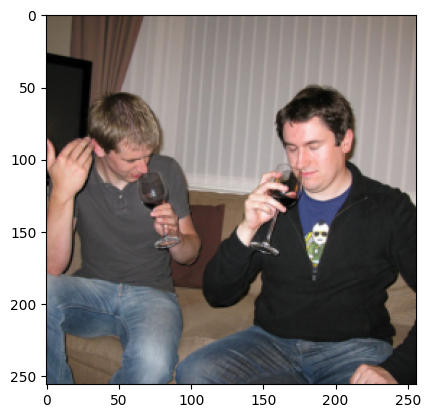

In [ ]:
img = Image.open(fnames[949]).convert('RGB')
transform = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.CenterCrop(IMAGE_SIZE),
    transforms.ToTensor(),
    tensor_normalizer  # Use the instance directly without calling it
])
img_tensor = transform(img).unsqueeze(0)
if torch.cuda.is_available():
    img_tensor = img_tensor.cuda()

img_output = transformer(img_tensor)  # Ensure img_tensor is a PyTorch tensor
plt.imshow(recover_image(img_tensor))  # This should work if img_tensor is a tensor

In [ ]:
Image.fromarray(recover_image(img_output.data.cpu().numpy())[0])

AttributeError: 'numpy.ndarray' object has no attribute 'tensor'

In [ ]:
save_model_path = "model_udnie.pth"
torch.save(transformer.state_dict(), save_model_path)

In [ ]:
transformer.load_state_dict(torch.load(save_model_path))

<All keys matched successfully>

In [ ]:
# Assuming TransformerNet is already defined
# If the TransformerNet code is not already in your script, you need to define it here
model = TransformerNet()

# Load the state dictionary
state_dict = torch.load('/content/model_udnie.pth')

# Update the model instance with the loaded state dictionary
model.load_state_dict(state_dict)

# Set the model to evaluation mode if you are doing inference
model.eval()

# Now you can use the model for inference

TransformerNet(
  (conv1): ConvLayer(
    (reflection_pad): ReflectionPad2d((4, 4, 4, 4))
    (conv2d): Conv2d(3, 32, kernel_size=(9, 9), stride=(1, 1))
  )
  (in1): InstanceNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
  (conv2): ConvLayer(
    (reflection_pad): ReflectionPad2d((1, 1, 1, 1))
    (conv2d): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2))
  )
  (in2): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
  (conv3): ConvLayer(
    (reflection_pad): ReflectionPad2d((1, 1, 1, 1))
    (conv2d): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2))
  )
  (in3): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
  (res1): ResidualBlock(
    (conv1): ConvLayer(
      (reflection_pad): ReflectionPad2d((1, 1, 1, 1))
      (conv2d): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
    )
    (in1): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
    (

In [ ]:
import matplotlib.pyplot as plt

def plot_images(original, style, styled):
    """
    Plots original, style, and styled images side by side.

    Args:
    - original: The original image.
    - style: The style reference image.
    - styled: The result of applying style transfer to the original image.
    """
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    titles = ['Original Image', 'Style Image', 'Styled Image']
    images = [original, style, styled]

    for ax, img, title in zip(axes, images, titles):
        ax.imshow(img)
        ax.set_title(title)
        ax.axis('off')
    plt.show()


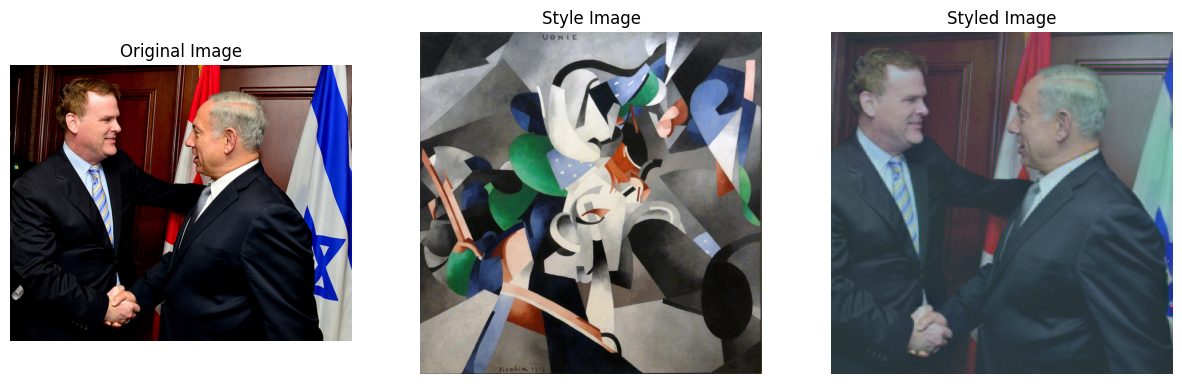

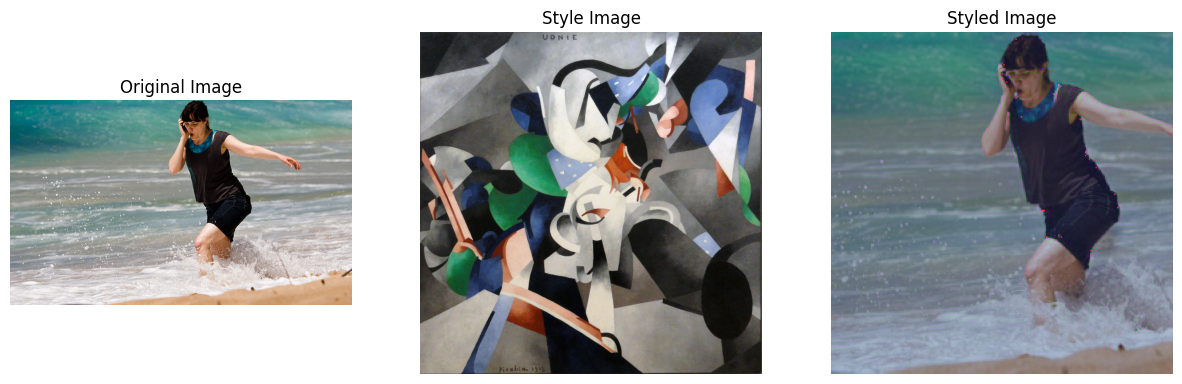

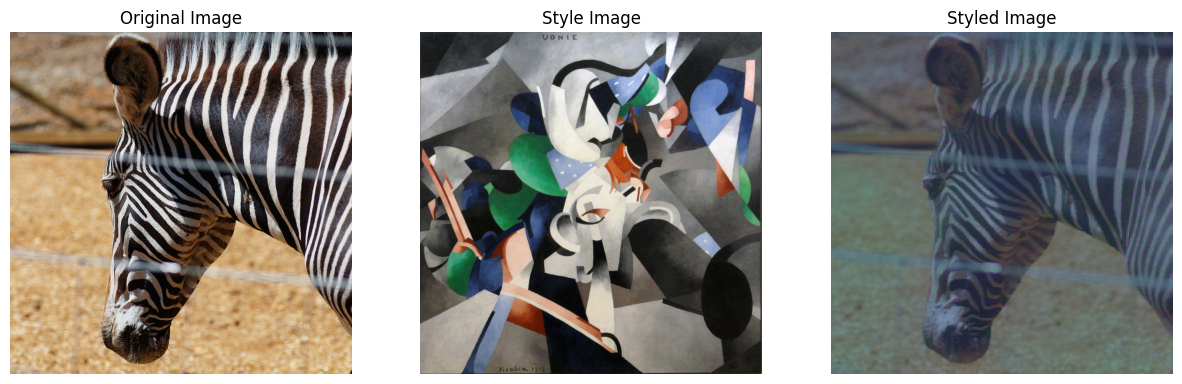

In [104]:
import torch
import os
import random
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import glob

# Assuming TransformerNet and TensorNormalizer are already defined and initialized

# Load the TransformerNet model
model = TransformerNet()
model.load_state_dict(torch.load('/content/model_udnie.pth'))
model.eval()

# If you're using CUDA, move the model to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define mean and std
mean = torch.tensor([0.485, 0.456, 0.406])
std = torch.tensor([0.229, 0.224, 0.225])

# Initialize the tensor normalizer
tensor_normalizer = TensorNormalizer(mean, std)

# Define the transformation
transform = transforms.Compose([
    transforms.Resize(256),  # Or your IMAGE_SIZE
    transforms.CenterCrop(256),  # Or your IMAGE_SIZE
    transforms.ToTensor(),
    tensor_normalizer
])

# Function to reverse normalization for visualization
def denormalize(tensor):
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
    return tensor

# Load and transform the style image
style_img_path = STYLE_IMAGE  # Replace with your style image path
style_img = Image.open(style_img_path).convert('RGB')
style_tensor = transform(style_img).unsqueeze(0).to(device)

# Directory containing your COCO images
image_directory = '/content/drive/MyDrive/data_coco/train2017'

image_files = glob.glob(image_directory + '/*.jpg')

# Ensure we don't try to sample more images than available
num_samples = min(3, len(image_files))

if num_samples == 0:
    raise ValueError("No .jpg files found in the specified directory.")

selected_image_paths = random.sample(image_files, num_samples)  # Adjust number as needed based on availability

def apply_style_transfer(input_img_path):
    input_img = Image.open(input_img_path).convert('RGB')
    input_tensor = transform(input_img).unsqueeze(0).to(device)

    with torch.no_grad():
        output_tensor = model(input_tensor)

    # Reverse normalization for display
    output_tensor = denormalize(output_tensor)

    # Convert tensor to PIL Image for plotting
    styled_img_plt = transforms.ToPILImage()(output_tensor.cpu().squeeze(0))
    return styled_img_plt

for input_img_path in selected_image_paths:
    styled_img_plt = apply_style_transfer(input_img_path)

    # Convert tensors to PIL Images for plotting
    original_img_plt = Image.open(input_img_path)
    style_img_plt = Image.open(style_img_path)

    # Plot the images
    plot_images(original_img_plt, style_img_plt, styled_img_plt)


In [ ]:
experiment.end()


In [69]:
from torch.optim import Adam
from torchvision import datasets
from torch.utils.data import DataLoader

# Assuming you have defined a loss function that combines content, style, and regularization losses
def compute_loss(model_output, content_targets, style_targets):
    # Implement your loss computation here
    return total_loss

# Prepare DataLoader for your training dataset
train_dataset = datasets.ImageFolder('/content/drive/MyDrive/data_coco', transform=transform)
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)

# Optimizer
optimizer = Adam(model.parameters(), lr=1e-3)

# Training Loop
model.train()
for epoch in range(epoch):
    for images, _ in train_loader:
        optimizer.zero_grad()
        if torch.cuda.is_available():
        # Forward pass
            outputs = model(images.cuda())

            # Compute loss
            loss = compute_loss(outputs, content_targets, style_targets)

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item()}")
